# Assignment 3 by: Jordan Pang (s3902159)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
from sklearn.metrics import average_precision_score

random.seed(15)

# Task 1: kNN-based Collaborative Filtering


In [2]:
# define columns for ratings.dat
ratings_columns = ["UserID", "MovieID", "Rating", "Timestamp"]
# import ratings.dat as df
ratings_df = pd.read_csv("ml-1m/ratings.dat", sep="::", names=ratings_columns, engine="python")
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
# define columns for movies.dat
movies_columns = ["MovieID", "Title", "Genres"]
# import movies.dat as df
movies_df = pd.read_csv("ml-1m/movies.dat", sep="::", names=movies_columns, engine="python", encoding="ISO-8859-1")
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# get number of unique users and movies
n_users = ratings_df.UserID.unique().shape[0]
n_movies = movies_df.MovieID.unique().shape[0]
print(f"{n_users} users")
print(f"{n_movies} movies")

6040 users
3883 movies


In [5]:
# create user_ratings matrix, loop is too slow
ratings_matrix = ratings_df.pivot_table(
    index='UserID',
    columns='MovieID',
    values='Rating',
    fill_value=0  
)

In [6]:
# choose random user as test
random_user_id = random.choice(ratings_df.UserID.unique())
print(f"Test User ID: {random_user_id}")

# get random_user_ratings
test_user_ratings = ratings_matrix.loc[random_user_id]

# create training set
train_ratings = ratings_matrix.drop(index=random_user_id)

# convert to numpy matrix
train_matrix = train_ratings.to_numpy()
test_user_matrix = test_user_ratings.to_numpy()

Test User ID: 1712


In [7]:
# fill missing values with 0 for cosine similarity
test_user_filled = test_user_matrix.reshape(1, -1)
train_ratings_filled = train_ratings.fillna(0).to_numpy()

In [8]:
def compute_centered_cosine(row, target):
    
    # get movies that both user rated
    valid = ~np.isnan(row) & ~np.isnan(target)
    
    # get common ratings
    user_ratings = row[valid]
    target_ratings = target[valid]
    
    # calculatge mean ratngs
    user_mean = np.nanmean(user_ratings)
    target_mean = np.nanmean(target_ratings)
    
    # center ratings by subtracting mean
    user_centered = user_ratings - user_mean
    target_centered = target_ratings - target_mean
    
    # calculate numerater and denominator
    numerator = np.dot(user_centered, target_centered)
    denominator = np.sqrt(np.dot(user_centered, user_centered)) * np.sqrt(np.dot(target_centered, target_centered))
    
    return numerator / denominator + 1e-9

In [9]:
def predict_ratings(similarities, train_matrix, k):

    top_k_indices = similarities.argsort()[-k:][::-1]

    # get top k similarities and corresponding user ratings
    top_k_similarities = similarities[top_k_indices]
    top_k_ratings = train_matrix[top_k_indices]

    # calculate similarity-weighted average
    weighted_sum = np.dot(top_k_similarities, top_k_ratings)

    # sum absolute values
    sum_similarities = np.abs(top_k_similarities).sum()

    # calculate the predicted ratings as the weighted average
    predicted_ratings = weighted_sum / sum_similarities
    
    return predicted_ratings


In [10]:
# calculate rmse between actual and predicted ratings
def calculate_rmse(actual, predicted):

    # get movies user has rated
    mask = ~np.isnan(actual)
    
    # get actual and predicted ratings
    y_true = actual[mask]
    y_pred = predicted[mask]
    
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [11]:
# calulate similarties between train and test user
cosine_similarities = cosine_similarity(train_ratings_filled, test_user_filled).flatten()
train_ratings_df = pd.DataFrame(train_ratings_filled, columns=train_ratings.columns, index=train_ratings.index)
centered_cosine_similarities = train_ratings_df.apply(lambda row: compute_centered_cosine(row, test_user_ratings), axis=1).fillna(0).to_numpy()

In [12]:
# list of k values to test
k_values = [5, 10, 20, 30, 50]

# stores test results
results = []

for k in k_values:
    # predict cosine similarity
    predicted_cosine = predict_ratings(cosine_similarities, train_matrix, k)
    # calculate rsme
    rmse_cosine = calculate_rmse(test_user_matrix, predicted_cosine)

    # predict centered cosine similarity
    predicted_centered_cosine = predict_ratings(centered_cosine_similarities, train_matrix, k)
    # calculate rsme
    rmse_centered_cosine = calculate_rmse(test_user_matrix, predicted_centered_cosine)

    # append results
    results.append({
        'k': k,
        'Similarity Metric': 'Cosine',
        'RMSE': rmse_cosine
    })
    results.append({
        'k': k,
        'Similarity Metric': 'Centered Cosine',
        'RMSE': rmse_centered_cosine
    })

# show results
results_df = pd.DataFrame(results)
print("\nEvaluation Results:")
print(results_df)



Evaluation Results:
    k Similarity Metric      RMSE
0   5            Cosine  0.982812
1   5   Centered Cosine  0.969956
2  10            Cosine  0.978254
3  10   Centered Cosine  0.936961
4  20            Cosine  0.970092
5  20   Centered Cosine  0.938411
6  30            Cosine  0.970759
7  30   Centered Cosine  0.937639
8  50            Cosine  0.965614
9  50   Centered Cosine  0.937339



Optimal k: 10
Best Similarity Metric: Centered Cosine
Lowest RMSE: 0.9370


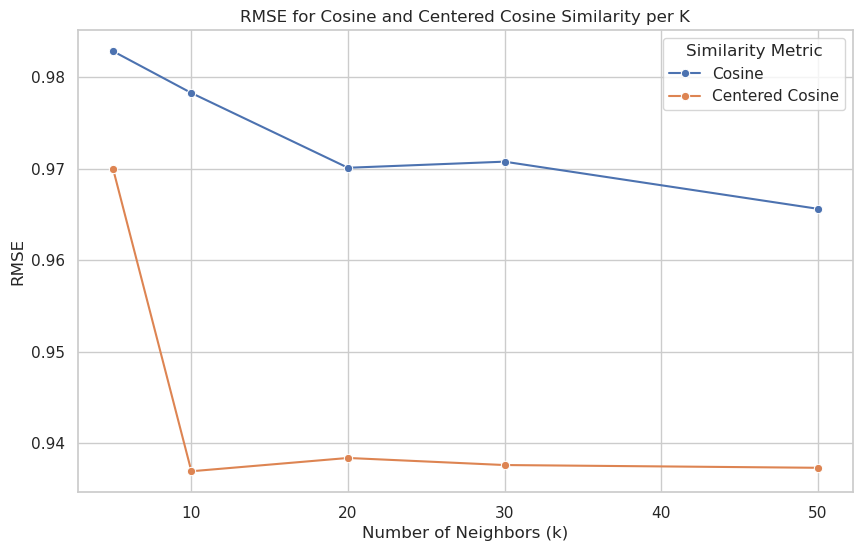

In [13]:
optimal_row = results_df.loc[results_df['RMSE'].idxmin()]
optimal_k = optimal_row['k']
optimal_metric = optimal_row['Similarity Metric']
optimal_rmse = optimal_row['RMSE']

print(f"\nOptimal k: {optimal_k}")
print(f"Best Similarity Metric: {optimal_metric}")
print(f"Lowest RMSE: {optimal_rmse:.4f}")

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='k', y='RMSE', hue='Similarity Metric', marker='o')
plt.title('RMSE for Cosine and Centered Cosine Similarity per K')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.legend(title='Similarity Metric')
plt.show()

# Task 2: Matrix Factorization-based Recommendation

In [14]:
# define columns for users.dat
users_columns = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]
# import users.dat as df
users_df = pd.read_csv("ml-1m/users.dat", sep="::", names=users_columns, engine="python")
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [15]:
# SVD parameters, deconstruct
rating_matrix = ratings_matrix.to_numpy()
U, s, Vt = svds(rating_matrix)
print(U.shape)
print(s.shape)
print(Vt.shape)

(6040, 6)
(6,)
(6, 3706)


In [16]:
sigma = np.diag(s)

# reconstruct ratings matrix
predicted_ratings_matrix = np.dot(np.dot(U, sigma), Vt)

# convert back to df
predicted_ratings_df = pd.DataFrame(predicted_ratings_matrix, columns=ratings_matrix.columns, index=ratings_matrix.index)
print(predicted_ratings_df.head())

MovieID      1         2         3         4         5         6         7     \
UserID                                                                          
1        1.751824  0.244750  0.211983  0.056873  0.174201 -0.326069  0.404085   
2        1.153659  0.255958  0.229254  0.071094  0.173009  1.287328  0.461180   
3        1.354922  0.299652  0.143961 -0.001171  0.091686  0.073186  0.184797   
4        0.417658  0.069586 -0.054706 -0.081009 -0.081361  0.283636 -0.103626   
5        1.168469 -0.092868  0.039106  0.091556 -0.047282  1.147452 -0.070903   

MovieID      8         9         10    ...      3943      3944      3945  \
UserID                                 ...                                 
1        0.043138 -0.064721  0.109654  ... -0.007240  0.004549  0.015544   
2        0.014616  0.097666  1.087260  ... -0.024573 -0.000209 -0.008717   
3        0.031427 -0.004350  0.390588  ... -0.008286  0.000969  0.014029   
4       -0.003552  0.011544  0.316175  ... -0.014353

In [17]:
# test set for movies
random_movies = np.random.choice(movies_df['MovieID'].unique(), 5, replace=False)
print("Movie test set:", random_movies)

Movie test set: [3840  411  909 1252  199]


In [18]:
# Initialize a list to store RMSE results
rmse_results = []

for movie_id in random_movies:
    # get actual ratings
    actual_ratings = ratings_matrix[movie_id].values
    
    # get predicted ratings
    predicted_ratings = predicted_ratings_df[movie_id].values
    
    # calculate RMSE
    rmse = calculate_rmse(actual_ratings, predicted_ratings)
    rmse_results.append({'MovieID': movie_id, "k" :"6",'RMSE': rmse})

rmse_df_svd = pd.DataFrame(rmse_results)
print("RMSE for Randomly Selected Test Movies:")
print(rmse_df_svd)

RMSE for Randomly Selected Test Movies:
   MovieID  k      RMSE
0     3840  6  0.351900
1      411  6  0.135531
2      909  6  0.910064
3     1252  6  1.372438
4      199  6  0.528169


In [19]:
# k values to test
k_values = [10,20, 50, 100]  
rmse_results = []

for k in k_values:
    print(f"Running SVD with k={k} latent factors...")
    
    # perform SVD decomposition
    U, s, Vt = svds(rating_matrix, k=k)
    
    # convert s to diagonal matrix
    sigma = np.diag(s)
    
    # reconstruct matrix
    predicted_ratings_matrix = np.dot(np.dot(U, sigma), Vt)
    
    # calculate RMSE for each movie
    for movie_id in ratings_matrix.columns:
        actual_ratings = rating_matrix[:, ratings_matrix.columns.get_loc(movie_id)]  
        predicted_ratings = predicted_ratings_matrix[:, ratings_matrix.columns.get_loc(movie_id)]  
        
        movie_rmse = calculate_rmse(actual_ratings, predicted_ratings)
        
        # store result
        if movie_rmse is not None:  
            rmse_results.append({
                'k': k,
                'MovieID': movie_id,
                'RMSE': movie_rmse
            })

rmse_df_svd_k = pd.DataFrame(rmse_results)
print("\nRMSE for Different k Values and Movies:")
print(rmse_df_svd_k)

Running SVD with k=10 latent factors...
Running SVD with k=20 latent factors...
Running SVD with k=50 latent factors...
Running SVD with k=100 latent factors...

RMSE for Different k Values and Movies:
         k  MovieID      RMSE
0       10        1  1.580613
1       10        2  0.898448
2       10        3  0.790911
3       10        4  0.447443
4       10        5  0.609966
...    ...      ...       ...
14819  100     3948  0.955110
14820  100     3949  0.728093
14821  100     3950  0.330975
14822  100     3951  0.308598
14823  100     3952  0.753196

[14824 rows x 3 columns]


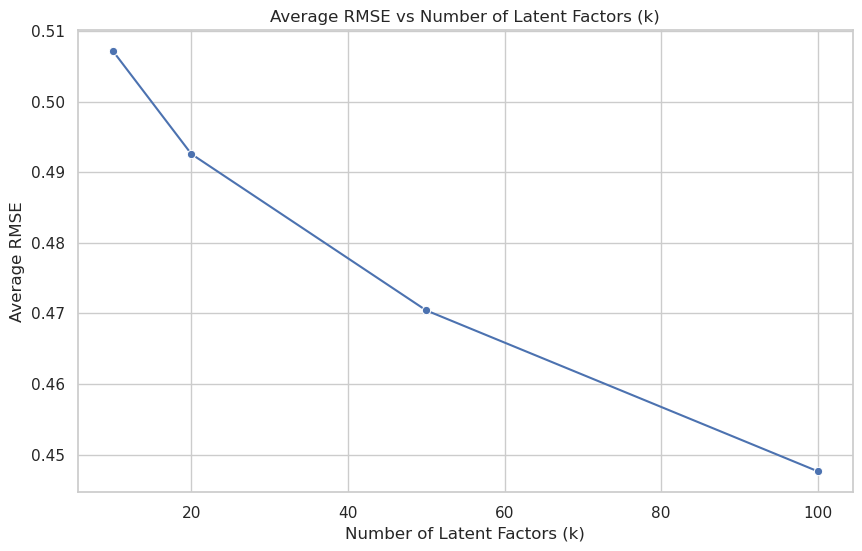

In [20]:
average_rmse = rmse_df_svd_k.groupby('k')['RMSE'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=average_rmse, x='k', y='RMSE', marker='o')
plt.title('Average RMSE vs Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.grid(True)
plt.show()

In [21]:
average_rmse_value = rmse_df_svd["RMSE"].mean()
print(f"Original SVD average RMSE: {average_rmse_value:.4f}")
average_rmse_k_100 = rmse_df_svd_k[rmse_df_svd_k["k"] == 100]["RMSE"].mean()
print(f"SVD k=100 average RMSE: {average_rmse_k_100:.4f}")

Original SVD average RMSE: 0.6596
SVD k=100 average RMSE: 0.4476


# Task 3: Ranking-based Evaluation and Comparison

In [22]:
# get eligible users
user_count = ratings_df.groupby('UserID').size()
eligible_users = user_count[user_count > 100].index
# select 10 users randomly
random_users = np.random.choice(eligible_users, 10, replace=False)
print(f"Selected Test Users: {random_users}")

Selected Test Users: [ 570 3713  551 4815 5757 2928 3075 4663  137 5890]


In [23]:
# calculate average precision
def calculate_ap(true_ratings, predicted_scores, k):
    k = 20
    top_k_indices = np.argsort(predicted_scores)[::-1][:k]
    
    # get true relevant items
    true_relevance = np.zeros_like(predicted_scores)
    true_relevance[true_ratings > 0] = 1  

    # get true relevance values to top-k predicted scores
    y_true = true_relevance[top_k_indices]
    y_score = predicted_scores[top_k_indices]

    # calculate ap
    return average_precision_score(y_true, y_score)

In [24]:
def calculate_ndcg(true_ratings, predicted_scores, k):
    k = 20
    top_k_indices = np.argsort(predicted_scores)[::-1][:k]

    # get true ratings and predicted scores
    true_relevance = np.array(true_ratings)[top_k_indices]

    # calculate DCG
    dcg = np.sum((2**true_relevance - 1) / np.log2(np.arange(2, k + 2)))

    # calculate IDCG
    ideal_relevance = np.sort(true_relevance)[::-1]
    idcg = np.sum((2**ideal_relevance - 1) / np.log2(np.arange(2, k + 2)))

    if idcg == 0:
        return 0.0

    # calculate ndcg
    return dcg / idcg

In [29]:
def get_knncf_recommendations(user_id, ratings_matrix, k=20):
    user_ratings = ratings_matrix.loc[user_id].values
    train_ratings = ratings_matrix.drop(index=user_id)
    train_ratings_df = train_ratings.fillna(0).astype(float)
    similarities = train_ratings_df.apply(lambda row: compute_centered_cosine(row, user_ratings), axis=1).to_numpy()
    train_matrix = train_ratings.to_numpy()
    predicted_scores = predict_ratings(similarities, train_matrix, k)
    return predicted_scores

def get_imfr_recommendations(user_id, ratings_matrix, k=50):
    rating_matrix = ratings_matrix.to_numpy()
    U, s, Vt = svds(rating_matrix, k=k)
    sigma = np.diag(s)
    predicted_ratings_matrix = np.dot(np.dot(U, sigma), Vt)
    predicted_ratings_df = pd.DataFrame(predicted_ratings_matrix, columns=ratings_matrix.columns, index=ratings_matrix.index)
    predicted_scores = predicted_ratings_df.loc[user_id].values
    return predicted_scores

In [30]:
# store evaluation results
results = []

for user_id in random_users:
    # KNNCF
    knncf_predicted_scores = get_knncf_recommendations(user_id, ratings_matrix)
    true_ratings_knn = ratings_matrix.loc[user_id].values
    
    # calculate AP and NDCG
    knn_ap = calculate_ap(true_ratings_knn, knncf_predicted_scores, 20)
    knn_ndcg = calculate_ndcg(true_ratings_knn, knncf_predicted_scores, 20)
    results.append({'UserID': user_id, 'Method': 'KNNCF', 'AP': knn_ap, 'NDCG': knn_ndcg})
    
    # IMFR (SVD k=100)
    imfr_predicted_scores = get_imfr_recommendations(user_id, ratings_matrix)
    true_ratings_imfr = ratings_matrix.loc[user_id].values
    
    # calculate AP and NDCG 
    imfr_ap = calculate_ap(true_ratings_imfr, imfr_predicted_scores, 20)
    imfr_ndcg = calculate_ndcg(true_ratings_imfr, imfr_predicted_scores, 20)
    results.append({'UserID': user_id, 'Method': 'IMFR', 'AP': imfr_ap, 'NDCG': imfr_ndcg})

# convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nEvaluation Results:")
print(results_df)


Evaluation Results:
    UserID Method        AP      NDCG
0      570  KNNCF  0.975888  0.950277
1      570   IMFR  0.988578  0.969768
2     3713  KNNCF  0.836754  0.821492
3     3713   IMFR  1.000000  0.989030
4      551  KNNCF  0.577030  0.724439
5      551   IMFR  1.000000  0.978159
6     4815  KNNCF  0.807015  0.906724
7     4815   IMFR  0.988578  0.857720
8     5757  KNNCF  0.985289  0.970422
9     5757   IMFR  0.994598  0.976492
10    2928  KNNCF  0.841521  0.857481
11    2928   IMFR  1.000000  0.998549
12    3075  KNNCF  0.970674  0.974036
13    3075   IMFR  1.000000  0.949093
14    4663  KNNCF  0.902594  0.670230
15    4663   IMFR  0.898479  0.926897
16     137  KNNCF  0.951770  0.851144
17     137   IMFR  0.997368  0.837592
18    5890  KNNCF  0.893394  0.887264
19    5890   IMFR  1.000000  0.970342


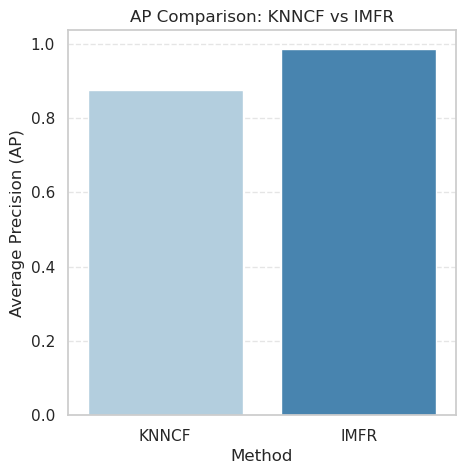

In [32]:
# barplot AP
plt.figure(figsize=(5, 5))
sns.barplot(data=results_df, x='Method', y='AP', errorbar=None, estimator=np.mean, palette='Blues', hue = "Method")
plt.title("AP Comparison: KNNCF vs IMFR")
plt.xlabel("Method")
plt.ylabel("Average Precision (AP)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

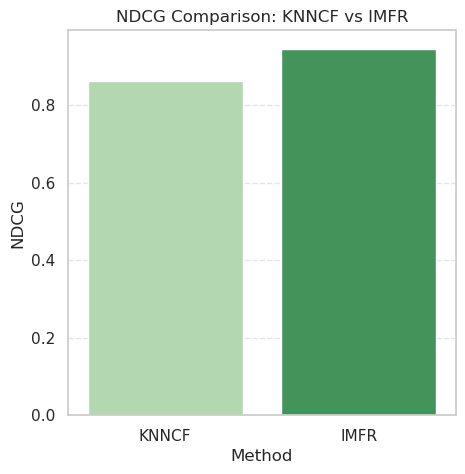

In [33]:
plt.figure(figsize=(5, 5))
sns.barplot(data=results_df, x="Method", y='NDCG', errorbar=None, estimator=np.mean, palette="Greens", hue="Method")
plt.title("NDCG Comparison: KNNCF vs IMFR")
plt.xlabel("Method")
plt.ylabel("NDCG")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()